Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.3) 미래에 볼 영화의 평점 예측하기

### 바로가기

- [<Step1. 탐색> : MovieLens 데이터 살펴보기](#<Step1.-탐색>-:-MovieLens-데이터-살펴보기)
    - [MovieLens 데이터셋의 기본 정보]
- [<Step2. 분석> : 탐색적 데이터 분석](#<Step2.-분석>-:-탐색적-데이터-분석)
    - [분석할 영화의 정보 탐색하기]
    - [장르의 속성 탐색]
    - [분석할 유저의 정보 탐색하기]
    - [평점 데이터의 정보 탐색하기]
    - [user-movie 형태의 테이블로 살펴보기]
- [<Step3. 예측> : 수학적 기법을 활용한 평점 예측](#<Step3.-예측>-:-수학적-기법을-활용한-평점-예측)
    - [SVD를 활용한 빈칸 채우기]
    - [아직 평가하지 않은 영화의 점수 예측하기]
- [<Step4. 평가> : 예측 모델 평가하기](#<Step4.-평가>-:-예측-모델-평가하기)
    - [예측 모델의 평가 방법]
    - [실제 평점과의 비교 시각화]
    - [한걸음 더 : 20대가 좋아할만한 영화를 예측해보자]

-----

In [ ]:
# -*- coding: utf-8 -*-

%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : MovieLens 데이터 살펴보기

### [MovieLens 데이터셋의 기본 정보]

In [56]:
# Data Source : https://grouplens.org/datasets/movielens

rating_file_path = "../data/ml-1m/ratings.dat"
movie_file_path = "../data/ml-1m/movies.dat"
user_file_path = "../data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

In [57]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [58]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [59]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [60]:
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


-----

# <Step2. 분석> : 탐색적 데이터 분석

### [분석할 영화의 정보 탐색하기]

In [61]:
movie_data

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [62]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

-----

### `[미니 퀴즈 - 3.3]`
- `영화 데이터에 대한 탐색적 데이터 분석을 더 실행해 봅시다. 영화의 연대별 갯수를 탐색해 보세요.`

In [63]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


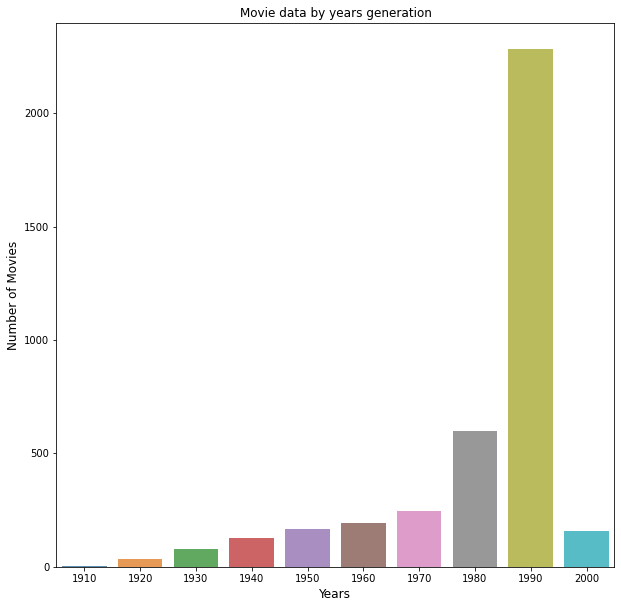

In [64]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

-----

### [장르의 속성 탐색] 

In [65]:
# 가장 많이 사용된 장르의 조합을 출력합니다. (Top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

-----

In [66]:
for index,row in movie_data.iterrows():
    print(row)

movie_id                               1
title                   Toy Story (1995)
genre        Animation|Children's|Comedy
year                                1995
year_term                           1990
Name: 0, dtype: object
movie_id                                2
title                      Jumanji (1995)
genre        Adventure|Children's|Fantasy
year                                 1995
year_term                            1990
Name: 1, dtype: object
movie_id                           3
title        Grumpier Old Men (1995)
genre                 Comedy|Romance
year                            1995
year_term                       1990
Name: 2, dtype: object
movie_id                            4
title        Waiting to Exhale (1995)
genre                    Comedy|Drama
year                             1995
year_term                        1990
Name: 3, dtype: object
movie_id                                      5
title        Father of the Bride Part II (1995)
genre                 

Name: 212, dtype: object
movie_id                       215
title        Before Sunrise (1995)
genre                Drama|Romance
year                          1995
year_term                     1990
Name: 213, dtype: object
movie_id                      216
title        Billy Madison (1995)
genre                      Comedy
year                         1995
year_term                    1990
Name: 214, dtype: object
movie_id                        217
title        Babysitter, The (1995)
genre                Drama|Thriller
year                           1995
year_term                      1990
Name: 215, dtype: object
movie_id                         218
title        Boys on the Side (1995)
genre                   Comedy|Drama
year                            1995
year_term                       1990
Name: 216, dtype: object
movie_id                  219
title        Cure, The (1995)
genre                   Drama
year                     1995
year_term                1990
Name: 217, dtyp

Name: 456, dtype: object
movie_id                461
title        Go Fish (1994)
genre         Drama|Romance
year                   1994
year_term              1990
Name: 457, dtype: object
movie_id                              462
title        Good Man in Africa, A (1994)
genre                    Action|Adventure
year                                 1994
year_term                            1990
Name: 458, dtype: object
movie_id                      463
title        Guilty as Sin (1993)
genre        Crime|Drama|Thriller
year                         1993
year_term                    1990
Name: 459, dtype: object
movie_id                                 464
title                     Hard Target (1993)
genre        Action|Adventure|Crime|Thriller
year                                    1993
year_term                               1990
Name: 460, dtype: object
movie_id                       465
title        Heaven & Earth (1993)
genre             Action|Drama|War
year                     

Name: 706, dtype: object
movie_id                            716
title        Switchblade Sisters (1975)
genre                             Crime
year                               1975
year_term                          1970
Name: 707, dtype: object
movie_id                                     717
title        Mouth to Mouth (Boca a boca) (1995)
genre                                     Comedy
year                                        1995
year_term                                   1990
Name: 708, dtype: object
movie_id                                      718
title        Visitors, The (Les Visiteurs) (1993)
genre                               Comedy|Sci-Fi
year                                         1993
year_term                                    1990
Name: 709, dtype: object
movie_id                     719
title        Multiplicity (1996)
genre                     Comedy
year                        1996
year_term                   1990
Name: 710, dtype: object
movie_id       

Name: 948, dtype: object
movie_id                               961
title        Little Lord Fauntleroy (1936)
genre                                Drama
year                                  1936
year_term                             1930
Name: 949, dtype: object
movie_id                                962
title        They Made Me a Criminal (1939)
genre                           Crime|Drama
year                                   1939
year_term                              1930
Name: 950, dtype: object
movie_id                               963
title        Inspector General, The (1949)
genre                              Musical
year                                  1949
year_term                             1940
Name: 951, dtype: object
movie_id                             964
title        Angel and the Badman (1947)
genre                            Western
year                                1947
year_term                           1940
Name: 952, dtype: object
movie_id            

Name: 1227, dtype: object
movie_id                         1248
title            Touch of Evil (1958)
genre        Crime|Film-Noir|Thriller
year                             1958
year_term                        1950
Name: 1228, dtype: object
movie_id                                1249
title        Nikita (La Femme Nikita) (1990)
genre                               Thriller
year                                    1990
year_term                               1990
Name: 1229, dtype: object
movie_id                                     1250
title        Bridge on the River Kwai, The (1957)
genre                                   Drama|War
year                                         1957
year_term                                    1950
Name: 1230, dtype: object
movie_id             1251
title        8 1/2 (1963)
genre               Drama
year                 1963
year_term            1960
Name: 1231, dtype: object
movie_id                           1252
title                  Chinatown (1

Name: 1436, dtype: object
movie_id                    1464
title        Lost Highway (1997)
genre                    Mystery
year                        1997
year_term                   1990
Name: 1437, dtype: object
movie_id                1465
title        Rosewood (1997)
genre                  Drama
year                    1997
year_term               1990
Name: 1438, dtype: object
movie_id                     1466
title        Donnie Brasco (1997)
genre                 Crime|Drama
year                         1997
year_term                    1990
Name: 1439, dtype: object
movie_id                     1467
title        Salut cousin! (1996)
genre                Comedy|Drama
year                         1996
year_term                    1990
Name: 1440, dtype: object
movie_id                  1468
title        Booty Call (1997)
genre           Comedy|Romance
year                      1997
year_term                 1990
Name: 1441, dtype: object
movie_id                      1470
titl

Name: 1601, dtype: object
movie_id                         1648
title        House of Yes, The (1997)
genre           Comedy|Drama|Thriller
year                             1997
year_term                        1990
Name: 1602, dtype: object
movie_id                                    1649
title        Fast, Cheap & Out of Control (1997)
genre                                Documentary
year                                        1997
year_term                                   1990
Name: 1603, dtype: object
movie_id                         1650
title        Washington Square (1997)
genre                           Drama
year                             1997
year_term                        1990
Name: 1604, dtype: object
movie_id                               1651
title        Telling Lies in America (1997)
genre                                 Drama
year                                   1997
year_term                              1990
Name: 1605, dtype: object
movie_id                 

Name: 1829, dtype: object
movie_id                             1899
title        Passion in the Desert (1998)
genre                     Adventure|Drama
year                                 1998
year_term                            1990
Name: 1830, dtype: object
movie_id                                                  1900
title        Children of Heaven, The (Bacheha-Ye Aseman) (1...
genre                                                    Drama
year                                                      1997
year_term                                                 1990
Name: 1831, dtype: object
movie_id                  1901
title        Dear Jesse (1997)
genre              Documentary
year                      1997
year_term                 1990
Name: 1832, dtype: object
movie_id                              1902
title        Dream for an Insomniac (1996)
genre                        Drama|Romance
year                                  1996
year_term                             1990
N

Name: 2074, dtype: object
movie_id                       2144
title        Sixteen Candles (1984)
genre                        Comedy
year                           1984
year_term                      1980
Name: 2075, dtype: object
movie_id                      2145
title        Pretty in Pink (1986)
genre         Comedy|Drama|Romance
year                          1986
year_term                     1980
Name: 2076, dtype: object
movie_id                       2146
title        St. Elmo's Fire (1985)
genre                 Drama|Romance
year                           1985
year_term                      1980
Name: 2077, dtype: object
movie_id                                  2147
title        Clan of the Cave Bear, The (1986)
genre                                    Drama
year                                      1986
year_term                                 1980
Name: 2078, dtype: object
movie_id              2148
title         House (1986)
genre        Comedy|Horror
year               

Name: 2351, dtype: object
movie_id                                2421
title        Karate Kid, Part II, The (1986)
genre                 Action|Adventure|Drama
year                                    1986
year_term                               1980
Name: 2352, dtype: object
movie_id                           2422
title        Karate Kid III, The (1989)
genre            Action|Adventure|Drama
year                               1989
year_term                          1980
Name: 2353, dtype: object
movie_id                          2423
title        Christmas Vacation (1989)
genre                           Comedy
year                              1989
year_term                         1980
Name: 2354, dtype: object
movie_id                       2424
title        You've Got Mail (1998)
genre                Comedy|Romance
year                           1998
year_term                      1990
Name: 2355, dtype: object
movie_id                    2425
title        General, The (1998)
genr

Name: 2606, dtype: object
movie_id                2676
title        Instinct (1999)
genre         Drama|Thriller
year                    1999
year_term               1990
Name: 2607, dtype: object
movie_id                               2677
title        Buena Vista Social Club (1999)
genre                           Documentary
year                                   1999
year_term                              1990
Name: 2608, dtype: object
movie_id                   2678
title        Desert Blue (1999)
genre                     Drama
year                       1999
year_term                  1990
Name: 2609, dtype: object
movie_id                     2679
title        Finding North (1999)
genre               Drama|Romance
year                         1999
year_term                    1990
Name: 2610, dtype: object
movie_id                2680
title        Floating (1997)
genre                  Drama
year                    1997
year_term               1990
Name: 2611, dtype: object
movi

Name: 2822, dtype: object
movie_id                      2892
title        New Rose Hotel (1998)
genre                 Action|Drama
year                          1998
year_term                     1990
Name: 2823, dtype: object
movie_id                           2893
title        Plunkett & MaCleane (1999)
genre                      Action|Drama
year                               1999
year_term                          1990
Name: 2824, dtype: object
movie_id               2894
title        Romance (1999)
genre         Drama|Romance
year                   1999
year_term              1990
Name: 2825, dtype: object
movie_id                             2895
title        Napoleon and Samantha (1972)
genre                           Adventure
year                                 1972
year_term                            1970
Name: 2826, dtype: object
movie_id                     2896
title        Alvarez Kelly (1966)
genre                     Western
year                         1966
year_term

Name: 3061, dtype: object
movie_id                       3131
title        Broadway Damage (1997)
genre                        Comedy
year                           1997
year_term                      1990
Name: 3062, dtype: object
movie_id                       3132
title        Daddy Long Legs (1919)
genre                        Comedy
year                           1919
year_term                      1910
Name: 3063, dtype: object
movie_id               3133
title        Go West (1925)
genre                Comedy
year                   1925
year_term              1920
Name: 3064, dtype: object
movie_id                                            3134
title        Grand Illusion (Grande illusion, La) (1937)
genre                                          Drama|War
year                                                1937
year_term                                           1930
Name: 3065, dtype: object
movie_id                          3135
title        Great Santini, The (1979)
genre  

Name: 3338, dtype: object
movie_id                       3408
title        Erin Brockovich (2000)
genre                         Drama
year                           2000
year_term                      2000
Name: 3339, dtype: object
movie_id                         3409
title        Final Destination (2000)
genre                  Drama|Thriller
year                             2000
year_term                        2000
Name: 3340, dtype: object
movie_id                  3410
title        Soft Fruit (1999)
genre             Comedy|Drama
year                      1999
year_term                 1990
Name: 3341, dtype: object
movie_id                  3411
title        Babymother (1998)
genre                    Drama
year                      1998
year_term                 1990
Name: 3342, dtype: object
movie_id                 3412
title        Bear, The (1988)
genre               Adventure
year                     1988
year_term                1980
Name: 3343, dtype: object
movie_id      

Name: 3559, dtype: object
movie_id                      3629
title        Gold Rush, The (1925)
genre                       Comedy
year                          1925
year_term                     1920
Name: 3560, dtype: object
movie_id                                                  3630
title        House of Exorcism, The (La Casa dell'esorcismo...
genre                                                   Horror
year                                                      1974
year_term                                                 1970
Name: 3561, dtype: object
movie_id                         3631
title        It's in the Water (1998)
genre                          Comedy
year                             1998
year_term                        1990
Name: 3562, dtype: object
movie_id                        3632
title        Monsieur Verdoux (1947)
genre                         Comedy
year                            1947
year_term                       1940
Name: 3563, dtype: object
movie

Name: 3840, dtype: object
movie_id                    3911
title        Best in Show (2000)
genre                     Comedy
year                        2000
year_term                   2000
Name: 3841, dtype: object
movie_id                 3912
title        Beautiful (2000)
genre            Comedy|Drama
year                     2000
year_term                2000
Name: 3842, dtype: object
movie_id                            3913
title        Barenaked in America (1999)
genre                        Documentary
year                                1999
year_term                           1990
Name: 3843, dtype: object
movie_id                               3914
title        Broken Hearts Club, The (2000)
genre                                 Drama
year                                   2000
year_term                              2000
Name: 3844, dtype: object
movie_id                 3915
title        Girlfight (2000)
genre                   Drama
year                     2000
year_term 

In [67]:
# 가장 많이 등장한 장르의 속성을 추출합니다. (예시 : Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


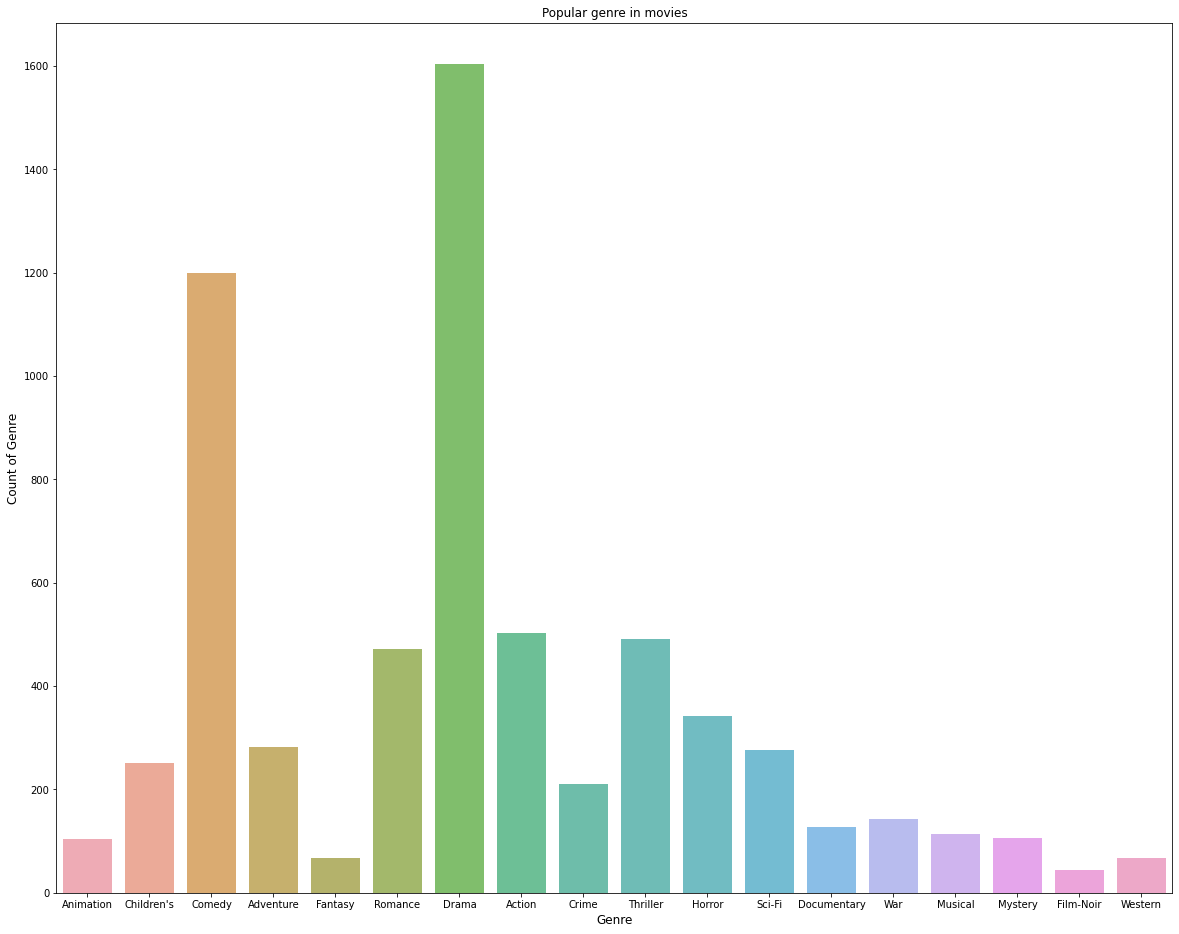

In [68]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

-----

### [분석할 유저의 정보 탐색하기]

In [69]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


-----

### `[미니 퀴즈 - 3.4]`
- `유저 데이터에 대한 탐색적 데이터 분석을 실행해 봅시다. 아래의 질문들에 답해보세요.` 
    - 유저의 성별 탐색
    - 유저의 연령대 탐색

M    4331
F    1709
Name: gender, dtype: int64


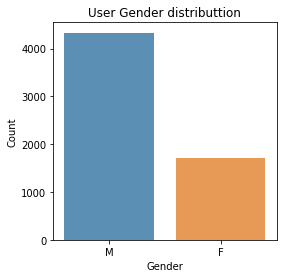

In [70]:
plt.figure(figsize=(4,4))
user_genders=user_data['gender'].value_counts()
print(user_genders)
sns.barplot(user_genders.index,user_genders.values,alpha=0.8)
plt.title("User Gender distributtion")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [71]:
user_data.columns

Index(['user_id', 'gender', 'age', 'occupation', 'zipcode'], dtype='object')

In [72]:
user_data.describe()

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [73]:
def age_converter(age):
    return (age//10)*10

In [74]:
user_data

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [75]:
plt.figure(figsize=(8,4))
user_data['ages']=user_data['age'].apply(lambda x: age_converter(x))
user_ages=user_data['ages'].value_counts()
user_ages

20    2096
30    1193
10    1103
50     876
40     550
0      222
Name: ages, dtype: int64

<Figure size 576x288 with 0 Axes>

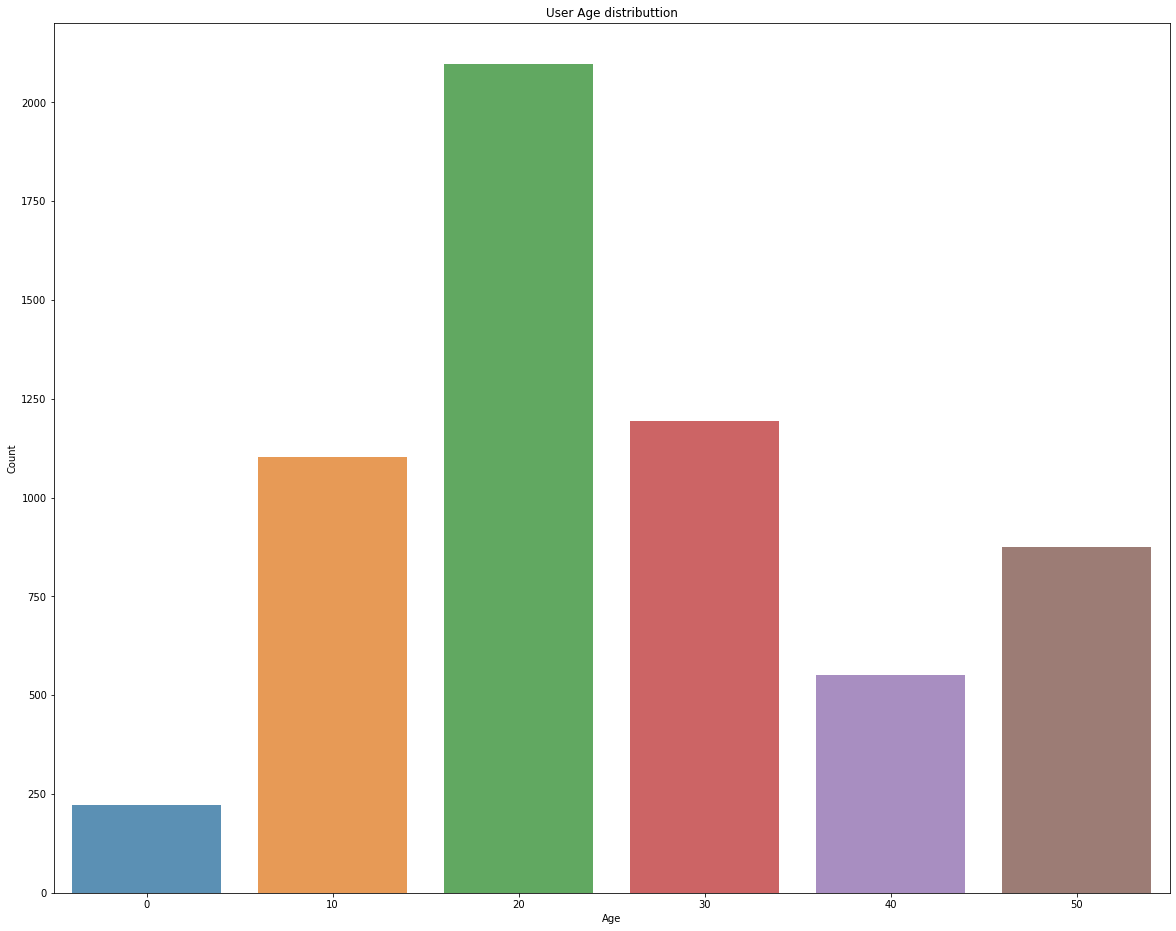

In [76]:
sns.barplot(user_ages.index,user_ages.values,alpha=0.8)
plt.title("User Age distributtion")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [77]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

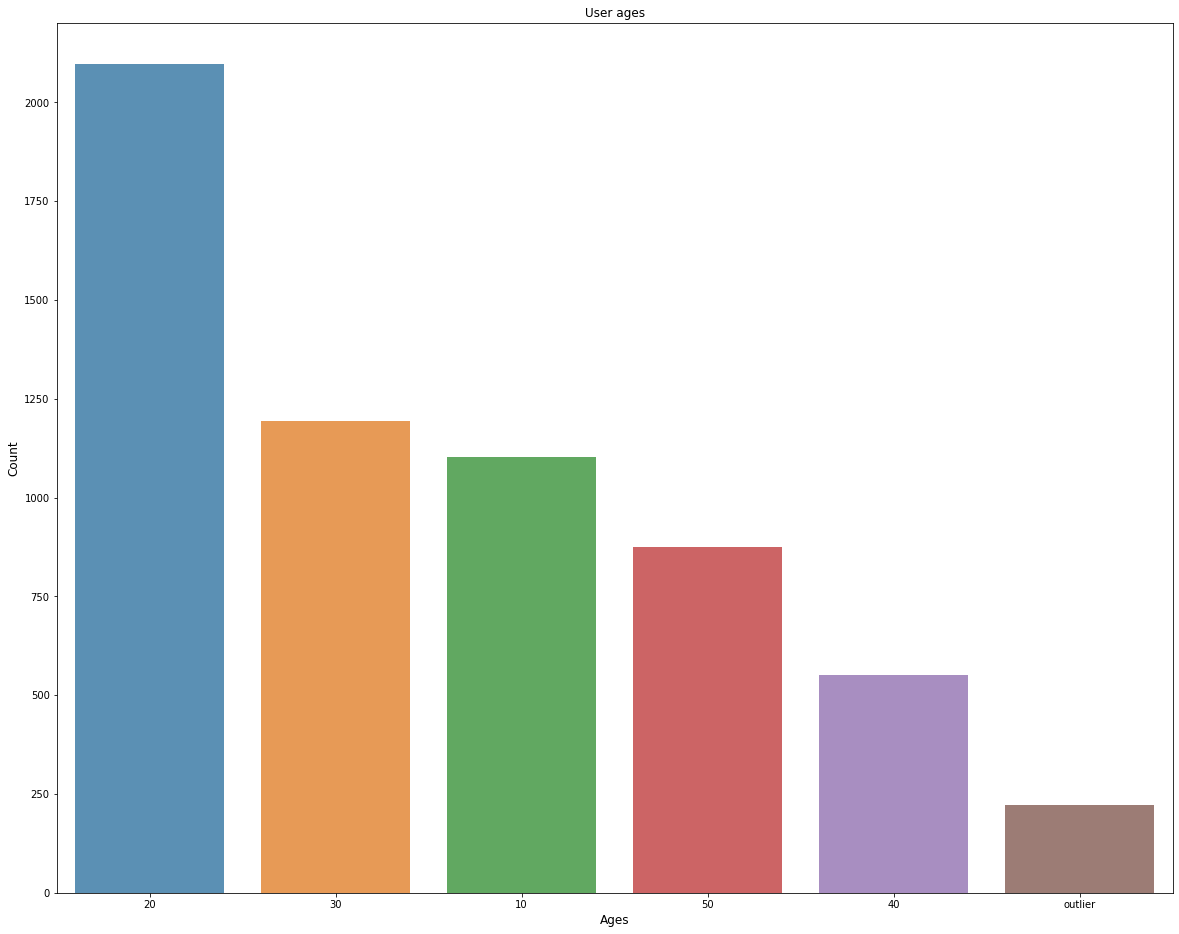

In [78]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

-----

### [평점 데이터의 정보 탐색하기]

In [79]:
ratings=rating_data.groupby('movie_id')['rating'].mean()

In [80]:
movie_data.join(ratings, on='movie_id')

,movie_id,title,genre,year,year_term,rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,1990,4.146846
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,1990,3.201141
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,1990,3.016736
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,1990,2.729412
4,5,Father of the Bride Part II (1995),Comedy,1995,1990,3.006757
...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000,2000,3.635731
3879,3949,Requiem for a Dream (2000),Drama,2000,2000,4.115132
3880,3950,Tigerland (2000),Drama,2000,2000,3.666667
3881,3951,Two Family House (2000),Drama,2000,2000,3.900000


In [81]:
rating_data

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


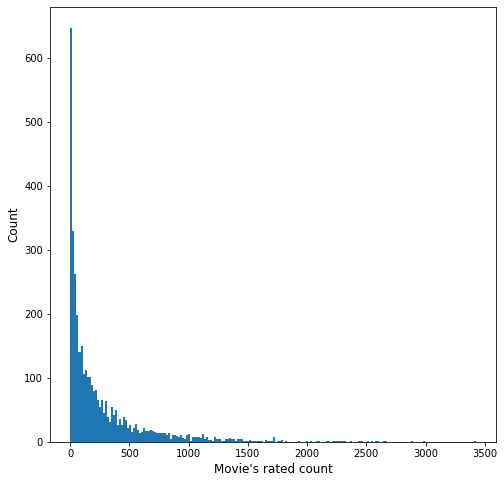

In [82]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [83]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


-----

In [84]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].agg(
    {'rated_count':'count', 'rating_mean':'mean'})

In [85]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


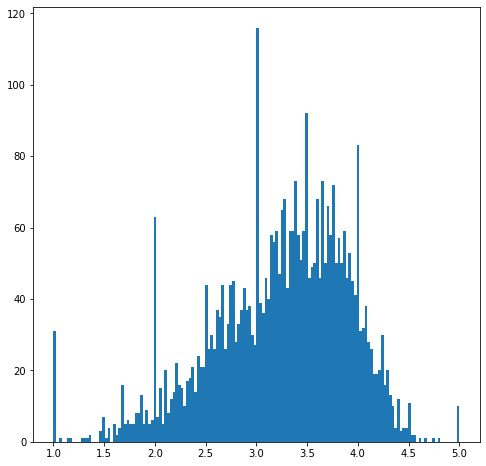

In [86]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

-----

In [87]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


-----

### `[미니 퀴즈 - 3.5]`
- `동일한 방식으로, 유저 그룹 단위의 평점 속성을 분석해 보세요.` 
    - 유저별로 평가한 영화 개수
    - 유저별로 평가한 평균 영화 점수
    - 유저별로 평가한 영화 점수의 편차

In [88]:
user_ratings=rating_data.groupby('user_id')['rating'].agg({'rated_count':'count', 
                                                                         'rating_mean':'mean', 
                                                                         'rating_std':'std'})
user_ratings

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699
...,...,...,...
6036,888,3.302928,1.023684
6037,202,3.717822,0.877910
6038,20,3.800000,1.105013


In [89]:
user_data.join(user_ratings,on='user_id')

,user_id,gender,age,occupation,zipcode,ages,rated_count,rating_mean,rating_std
0,1,F,1,10,48067,outlier,53,4.188679,0.680967
1,2,M,56,16,70072,50,129,3.713178,1.001513
2,3,M,25,15,55117,20,51,3.901961,0.984985
3,4,M,45,7,02460,40,21,4.190476,1.077917
4,5,M,25,20,55455,20,198,3.146465,1.132699
...,...,...,...,...,...,...,...,...,...
6035,6036,F,25,15,32603,20,888,3.302928,1.023684
6036,6037,F,45,1,76006,40,202,3.717822,0.877910
6037,6038,F,56,1,14706,50,20,3.800000,1.105013
6038,6039,F,45,0,01060,40,123,3.878049,0.730881


In [90]:
# 유저별 영화 평가를 탐색합니다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg({'rated_count':'count', 
                                                                         'rating_mean':'mean', 
                                                                         'rating_std':'std'})

In [91]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


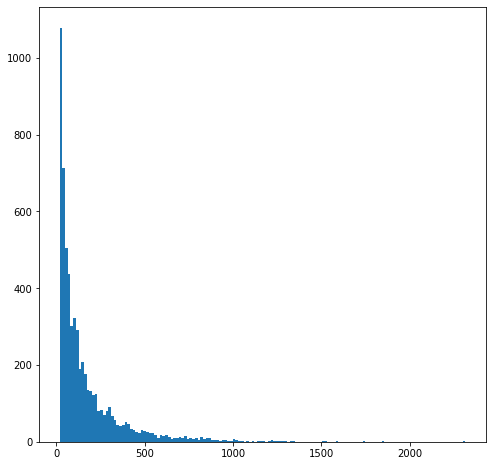

In [92]:
# 유저별로 평가한 영화 개수의 분포를 출력합니다.
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

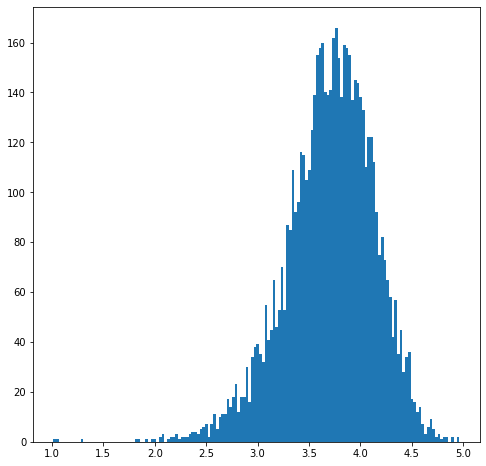

In [93]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

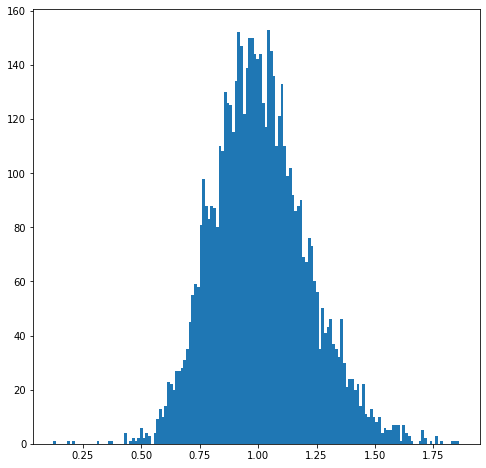

In [94]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

-----

### [user-movie 형태의 테이블로 살펴보기]

In [95]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [96]:
rating_data[['user_id','movie_id','rating']].set_index(["user_id","movie_id"]).unstack()

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6036        NaN  NaN  NaN  2.0  NaN  3.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6037        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6038        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6039        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6040        3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...       ...  ...  ...  ...  ...  ...  ...  ...  
6036      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6037      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6038      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6039      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6040      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[6040 rows x 3706 columns]

In [97]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

-----

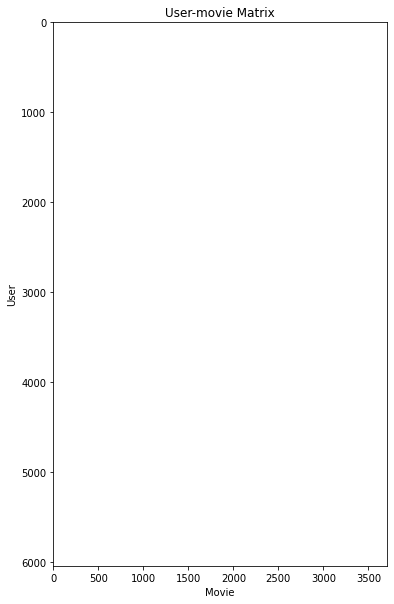

In [98]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

-----

# <Step3. 예측> : 수학적 기법을 활용한 평점 예측

### [SVD를 활용한 빈칸 채우기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지를 설치해 줍니다.
    - (env_name) `pip install surprise`

-----

##### 빈칸을 포함한 user-item 행렬 생성

In [99]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

In [100]:
# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [101]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

-----

##### SVD를 이용한 빈칸 채우기 학습

In [102]:
# SVD 사용을 위한 데이터셋을 생성합니다.
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

In [103]:
# SVD 모델을 학습합니다.
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [104]:
# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

Item id 1 | predicted rating : 3.6410872645094563
Item id 3 | predicted rating : 3.761656665229871


In [105]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.4677737555605956
Item id 2 | real rating : 4.0 | predicted rating : 3.809335995078689
Item id 3 | real rating : 4.0 | predicted rating : 3.6884924985656533
Item id 1 | real rating : 2.0 | predicted rating : 3.58491664572844
Item id 2 | real rating : 5.0 | predicted rating : 3.8882282398553314
Item id 3 | real rating : 4.0 | predicted rating : 3.7234748332691225
Item id 2 | real rating : 5.0 | predicted rating : 3.9067792217721853


-----

### [아직 평가하지 않은 영화의 점수 예측하기]

##### MovieLens 데이터에 SVD 적용하기

In [106]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 108.22 seconds


-----

##### 영화의 점수를 예측할 타겟 유저 선정

In [107]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [108]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


-----

##### 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [109]:
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [110]:
target_user_movie_rating_dict

{3468: 5,
 1210: 3,
 2951: 4,
 1214: 4,
 1036: 4,
 260: 5,
 2028: 5,
 480: 4,
 1196: 2,
 1198: 5,
 1954: 5,
 1097: 4,
 3418: 4,
 3702: 4,
 2366: 4,
 1387: 5,
 3527: 1,
 1201: 5,
 2692: 5,
 2947: 5,
 1240: 5}

In [111]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [112]:
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

In [113]:
# 예측된 Top 10 영화
target_user_top10_predicted

[(53, 5),
 (111, 5),
 (175, 5),
 (246, 5),
 (326, 5),
 (527, 5),
 (567, 5),
 (602, 5),
 (608, 5),
 (615, 5)]

In [114]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [115]:
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Lamerica (1994) : 5
Taxi Driver (1976) : 5
Kids (1995) : 5
Hoop Dreams (1994) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Kika (1993) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5


In [116]:
# 타겟 유저의 기존 선호 영화와 비교합니다.
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


-----

# <Step4. 평가> : 예측 모델 평가하기

### [예측 모델의 평가 방법]

##### RMSE 계산하기

In [117]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 102.19 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8610


0.8610201072201727

-----

### `[미니 퀴즈 - 3.6]`
- `SVD 예제에서 하이퍼 파라미터를 바꿔가며 RMSE를 출력해 보세요.` 
    - RMSE를 이용해 적당한 하이퍼 파라미터 n_factors를 찾아봅시다.
    - 하이퍼 파라미터 n_factors 설정 변화에 따른 RMSE 그래프를 출력해 보세요.

##### 하이퍼 파라미터 튜닝 예시

In [118]:
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(1, 15):    
    train_start = time.time()
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 87.19 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8840
------------------------------------
training time of model: 90.51 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8742
------------------------------------
training time of model: 93.81 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8679
------------------------------------
training time of model: 92.93 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8630
------------------------------------
training time of model: 93.60 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8602
------------------------------------
training time of model: 102.14 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8598
------------------------------------
training time of model: 86.51 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8611
------------------------------------
training time of model: 104.35 seconds
RMSE of test da

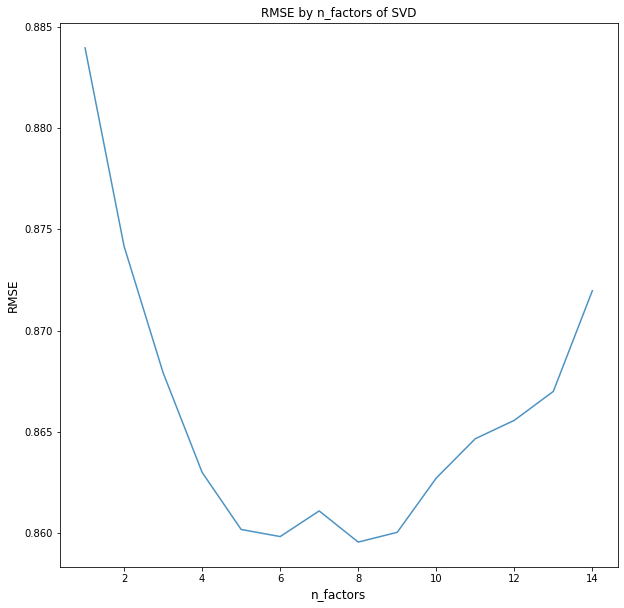

In [119]:
plt.plot(range(1, 15), rmse_list_by_factors, alpha=0.8)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

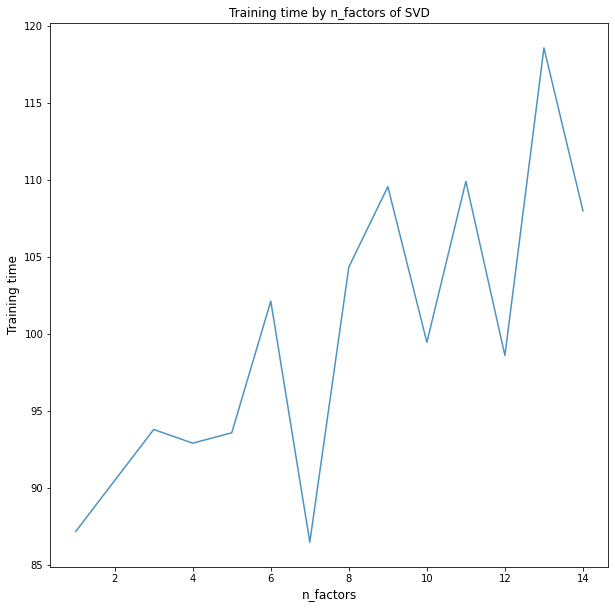

In [120]:
plt.plot(range(1, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

-----

### [실제 평점과의 비교 시각화]

##### 평점 예측 단계

In [121]:
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

In [122]:
len(test_data)

21

In [123]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [124]:
target_user_predictions

[Prediction(uid=4, iid=260, r_ui=5, est=4.100292067309081, details={'was_impossible': False}),
 Prediction(uid=4, iid=480, r_ui=4, est=3.6049800031175616, details={'was_impossible': False}),
 Prediction(uid=4, iid=1036, r_ui=4, est=3.801517999065345, details={'was_impossible': False}),
 Prediction(uid=4, iid=1097, r_ui=4, est=4.202207232664275, details={'was_impossible': False}),
 Prediction(uid=4, iid=1196, r_ui=2, est=3.7240427526972195, details={'was_impossible': False}),
 Prediction(uid=4, iid=1198, r_ui=5, est=4.48103002878614, details={'was_impossible': False}),
 Prediction(uid=4, iid=1201, r_ui=5, est=4.663538926113086, details={'was_impossible': False}),
 Prediction(uid=4, iid=1210, r_ui=3, est=3.355852752764826, details={'was_impossible': False}),
 Prediction(uid=4, iid=1214, r_ui=4, est=4.3896609238685205, details={'was_impossible': False}),
 Prediction(uid=4, iid=1240, r_ui=5, est=4.144961779363799, details={'was_impossible': False}),
 Prediction(uid=4, iid=1387, r_ui=5, est

In [125]:
target_user_movie_predict_dict

{260: 4.100292067309081,
 480: 3.6049800031175616,
 1036: 3.801517999065345,
 1097: 4.202207232664275,
 1196: 3.7240427526972195,
 1198: 4.48103002878614,
 1201: 4.663538926113086,
 1210: 3.355852752764826,
 1214: 4.3896609238685205,
 1240: 4.144961779363799,
 1387: 4.554668499618083,
 1954: 4.3351409642156264,
 2028: 4.5741191699740025,
 2366: 4.013310990205063,
 2692: 3.8957126906983044,
 2947: 4.311274345073253,
 2951: 4.505343669916469,
 3418: 4.268761181713375,
 3468: 5,
 3527: 2.9781629670427634,
 3702: 3.743069903423391}

In [126]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.1
movie 2 : Jurassic Park (1993) - 4 / 3.6
movie 3 : Die Hard (1988) - 4 / 3.8
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.2
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.72
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.48
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.66
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.36
movie 9 : Alien (1979) - 4 / 4.39
movie 10 : Terminator, The (1984) - 5 / 4.14
movie 11 : Jaws (1975) - 5 / 4.55
movie 12 : Rocky (1976) - 5 / 4.34
movie 13 : Saving Private Ryan (1998) - 5 / 4.57
movie 14 : King Kong (1933) - 4 / 4.01
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 3.9
movie 16 : Goldfinger (1964) - 5 / 4.31
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.51
movie 18 : Thelma & Louise (1991) - 4 / 4.27
movie 19 : Hustler, The (1961) - 5 / 5
movie 20 : Predator (1987) - 1 / 2.98
movie 21 : Mad Max (1979) - 4 / 3.74


-----

##### 결과의 시각화

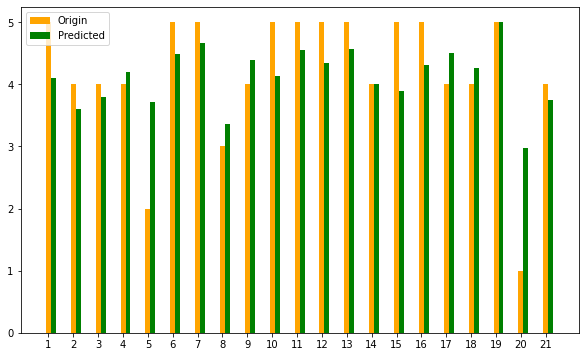

In [127]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

-----

### `한걸음 더 나아가기`
- `20대가 좋아할만한 영화 예측하기.` 

##### 20대 유저 리스트 선정

In [128]:
user_age_20_list = user_data[user_data['ages']=="20"]['user_id'].tolist()

- 평가하지 않은 user-movie rating들에 대한 예측값을 통해, 20대가 좋아할 것 같은 영화 리스트 선정

-----

##### (참고) 아래의 코드는 약 10분 이상이 소요되는 과정입니다.

In [129]:
# 평가하지 않은 user-movie rating들에 대한 예측값을 계산합니다.
preprocess_start = time.time()
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 평가하지 않은 user-movie rating 중에서, 20대의 예측값을 선별합니다.
hidden_user_age_20_movie_predict_dict = {}
for uid, mid, _, predicted_rating, _ in predictions:
    if uid in user_age_20_list:
        if mid in hidden_user_age_20_movie_predict_dict:
            hidden_user_age_20_movie_predict_dict[mid]['sum'] += predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] += 1
        else:
            hidden_user_age_20_movie_predict_dict[mid] = {}
            hidden_user_age_20_movie_predict_dict[mid]['sum'] = predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] = 1

# 영화마다 20대 유저의 rating 평균값을 계산합니다.
for movie_id, score_dict in hidden_user_age_20_movie_predict_dict.items():
    score_dict['mean'] = score_dict['sum'] / score_dict['count']
    
# Top 10 movie_id를 추출합니다.
hidden_user_age_20_movie_list = sorted(hidden_user_age_20_movie_predict_dict, 
                                       key=lambda x: (hidden_user_age_20_movie_predict_dict[x]['mean']), 
                                       reverse=True)[:10]

preprocess_end = time.time()
print("preprocess time: %.2f seconds" % (preprocess_end - preprocess_start))

preprocess time: 714.04 seconds


In [130]:
hidden_user_age_20_movie_predict_dict 

{2058: {'sum': 6415.110296861483, 'count': 1831, 'mean': 3.5036102112842618},
 3515: {'sum': 6508.293066034735, 'count': 2045, 'mean': 3.1825393965940023},
 1593: {'sum': 5555.6551070821415, 'count': 2043, 'mean': 2.7193612858943426},
 2243: {'sum': 6604.144085259516, 'count': 1850, 'mean': 3.5698076136537926},
 1917: {'sum': 5044.965838150346, 'count': 1743, 'mean': 2.8944152829319254},
 2541: {'sum': 6014.5239137555545, 'count': 1909, 'mean': 3.1506149364879805},
 920: {'sum': 6867.922876554268, 'count': 1816, 'mean': 3.781895857133408},
 1876: {'sum': 5375.009541318473, 'count': 1804, 'mean': 2.9794953111521467},
 3536: {'sum': 7173.4588400630255, 'count': 1928, 'mean': 3.7206736722318596},
 1672: {'sum': 7098.492954893688, 'count': 1996, 'mean': 3.556359195838521},
 2067: {'sum': 7889.481586855972, 'count': 1989, 'mean': 3.966556856136738},
 1885: {'sum': 6485.498962892857, 'count': 1881, 'mean': 3.447899501803752},
 1680: {'sum': 7326.236721566422, 'count': 1949, 'mean': 3.7589721

In [134]:
sorted(hidden_user_age_20_movie_predict_dict,key=lambda x:(hidden_user_age_20_movie_predict_dict[x]['mean']))

[3574,
 1383,
 1311,
 1495,
 3945,
 810,
 1323,
 1989,
 2449,
 2818,
 1826,
 1731,
 3593,
 2383,
 1739,
 2799,
 2974,
 2368,
 2555,
 3799,
 1595,
 2807,
 66,
 3664,
 2382,
 1105,
 2537,
 2516,
 3042,
 3940,
 1538,
 2777,
 3572,
 102,
 3573,
 1325,
 3665,
 3268,
 3166,
 126,
 1389,
 3027,
 2452,
 2817,
 1328,
 1996,
 1707,
 1490,
 3041,
 1993,
 3939,
 1556,
 2515,
 181,
 1990,
 519,
 169,
 393,
 470,
 2643,
 3463,
 546,
 703,
 3667,
 2816,
 2614,
 3001,
 1681,
 3931,
 1599,
 1381,
 2514,
 220,
 3440,
 2153,
 1335,
 3564,
 2798,
 2298,
 2655,
 1981,
 1998,
 1984,
 2381,
 1720,
 3043,
 2965,
 3392,
 737,
 3054,
 212,
 3877,
 2536,
 3439,
 2548,
 3433,
 2386,
 1679,
 2828,
 3933,
 3663,
 2903,
 1992,
 747,
 667,
 3768,
 3390,
 1324,
 2720,
 1976,
 1760,
 3820,
 1862,
 3942,
 2412,
 1322,
 2701,
 3488,
 2982,
 193,
 3767,
 1980,
 3694,
 2486,
 2380,
 2552,
 502,
 75,
 2450,
 374,
 2422,
 3434,
 1978,
 2392,
 1168,
 1427,
 1972,
 3938,
 243,
 71,
 704,
 65,
 3190,
 2748,
 870,
 2152,
 1445,


In [135]:
# 선정된 리스트를 출력합니다.
print("20대가 좋아할지도 모르는 영화 Top 10")
print("---------------------------------")
for movie_id in hidden_user_age_20_movie_list:
    movie_title = movie_dict[movie_id]
    age_20_rating = hidden_user_age_20_movie_predict_dict[movie_id]['mean']
    print("title:", movie_title, "| rating:", age_20_rating)

20대가 좋아할지도 모르는 영화 Top 10
---------------------------------
title: Sanjuro (1962) | rating: 4.600830648773194
title: Usual Suspects, The (1995) | rating: 4.503732835023327
title: Shawshank Redemption, The (1994) | rating: 4.4641228627056595
title: West Beirut (West Beyrouth) (1998) | rating: 4.44630026759655
title: Apple, The (Sib) (1998) | rating: 4.436032468241264
title: Lamerica (1994) | rating: 4.427610270056453
title: Schindler's List (1993) | rating: 4.41509507300729
title: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) | rating: 4.402417148313008
title: Gate of Heavenly Peace, The (1995) | rating: 4.387757025087053
title: For All Mankind (1989) | rating: 4.38667710358218


In [146]:
a=[(1,4),(2,3),(2,1),(5,2),(6,2),(1,3)]
a

[(1, 4), (2, 3), (2, 1), (5, 2), (6, 2), (1, 3)]

In [139]:
a.sort()

In [147]:
sorted(a,key=lambda x:x[0])

[(1, 4), (1, 3), (2, 3), (2, 1), (5, 2), (6, 2)]